<a href="https://colab.research.google.com/github/ablacan/BlendHunter/blob/master/Labwork2_OPT10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Image Classification

Welcome to deep learning for image classification tutorial!
**In this notebook, you will**:
- Learn the basics of PyTorch, a powerful but easy to use package for scientific computing (and deep learning)
- Learn how to build and train a convolutional neural network for image classification.

If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.


## I. PyTorch Tutorial

We will briefly go through the basics of the PyTorch package, playing with toy examples.

If you know already how to use PyTorch, then you can directly go to the second part of this tutorial

## II. Training a classifier

In this part, we will train a Convolutional Neural Network to classify images of 10 different classes (dogs, cats, car, ...) and see how our model performs on the test set.  


## III. Exploring CNN Architectures

This is the part where you get your hands dirty ;). Your mission is to experiment different CNN architectures and set hyperparameters in order to obtain the best accuracy on the test set!


The following command sets the backend of matplotlib to the 'inline' backend so that the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it:

In [1]:
%matplotlib inline

### Plotting functions and useful imports

You can skip this part

In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as th

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# II. Training a classifier


For this tutorial, we will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10 Dataset

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

Seed the random generator to have reproducible results:

In [16]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


### Define subset of the dataset (so it is faster to train)

## **NOTE**
**Here, we decided to create a training set of 45 000 images and a validation set of 5000 images. More data in the validation set should help a little bit with the training especially because we have 10 classes to predict. For the rest of the notebook, this is the configuration we will keep, with 10 000 test images.**

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 45000 # Max: 50 000 - n_val_samples
n_val_samples = 5000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))  # we can use it to test on a subset
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [18]:
num_workers = 5
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.




     horse      truck        dog      horse


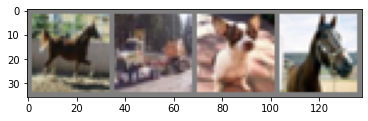

In [19]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

### 2. Define a Convolution Neural Network


In [20]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

#### Simple Convolutional Neural Network

ConvNet with one convolution layer followed by a max pooling operation,
one fully connected layer and an output layer

In [21]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

#### Linear Classifier

In [22]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

### 3. Define a loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionally, SGD with momentum). You can read more about  [optimization methods](https://pytorch.org/docs/stable/optim.html).



In [23]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, feed the inputs to the network, and optimize



#### Data loader

In [24]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 32

## **NOTE**

**The following `train`function will be used throughout the whole script. We added a function in order to reduce the learning rate by a default rate of 0.1, after 2 epochs (`patience = 3`) if the validation loss has not decreased. This is implemented thanks to pytorch function `ReduceLROnPlateau`.**

In [57]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    #LR decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        """Modifications : LR decay"""
        scheduler.step(total_val_loss)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [26]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.01 took: 1.58s
Epoch 1, 20% 	 train_loss: 1.73 took: 1.33s
Epoch 1, 30% 	 train_loss: 1.58 took: 1.30s
Epoch 1, 40% 	 train_loss: 1.51 took: 1.29s
Epoch 1, 50% 	 train_loss: 1.46 took: 1.35s
Epoch 1, 60% 	 train_loss: 1.40 took: 1.31s
Epoch 1, 70% 	 train_loss: 1.37 took: 1.32s
Epoch 1, 80% 	 train_loss: 1.35 took: 1.30s
Epoch 1, 90% 	 train_loss: 1.32 took: 1.32s
Validation loss = 1.29
Epoch 2, 10% 	 train_loss: 1.26 took: 1.56s
Epoch 2, 20% 	 train_loss: 1.22 took: 1.32s
Epoch 2, 30% 	 train_loss: 1.24 took: 1.30s
Epoch 2, 40% 	 train_loss: 1.21 took: 1.32s
Epoch 2, 50% 	 train_loss: 1.18 took: 1.31s
Epoch 2, 60% 	 train_loss: 1.20 took: 1.30s
Epoch 2, 70% 	 train_loss: 1.17 took: 1.35s
Epoch 2, 80% 	 train_loss: 1.19 took: 1.33s
Epoch 2, 90% 	 train_loss: 1.15 took: 1.32s
Validation loss = 1.17
Epoch 3, 10% 	 train_loss: 1.08 took: 1.51s
Epoch 3, 20% 	 train_loss: 1.09 took: 1.3

Now, let's look at the evolution of the losses

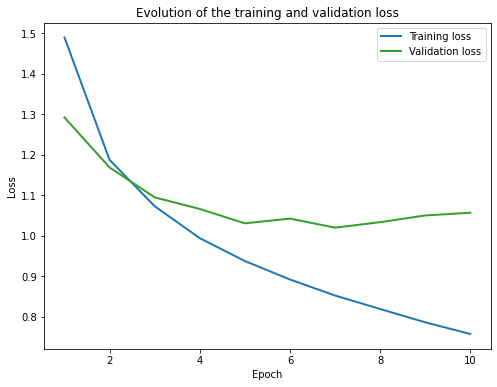

In [27]:
plot_losses(train_history, val_history)

### 5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Ground truth:

       cat       ship       ship      plane


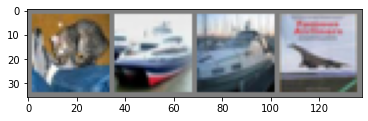

In [28]:
try:
  images, labels = next(iter(test_loader))
except EOFError:
  pass

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

Okay, now let us see what the neural network thinks these examples above are:



In [29]:
outputs = net(images.to(device))
print(outputs.size())

torch.Size([4, 10])


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is from that particular class.
So, let's get the index of the highest energy:



Predicted:

       cat        car      plane       ship


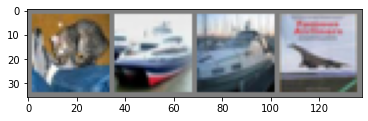

In [30]:
_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

The results seem pretty good.

Let us look at how the network performs on the whole test set.



In [31]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 45000 train images: 73.76 %
Accuracy of the network on the 5000 validation images: 65.62 %
Accuracy of the network on the 10000 test images: 63.57 %


That initial 63.78 % on the test set of images looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.
As a baseline, a linear model achieves around 30% accuracy.

What are the classes that performed well, and the classes that did not perform well?



In [32]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        72.70   
car          72.50   
bird         44.40   
cat          42.60   
deer         52.50   
dog          52.70   
frog         78.40   
horse        75.30   
ship         73.70   
truck        70.90   


### Confusion Matrix

Let's look at what type of error our networks makes... 
It seems that our network is pretty good at classifying ships,
but has some difficulties to differentiate cats and dogs.
Also, it classifies a lot of trucks as cars.

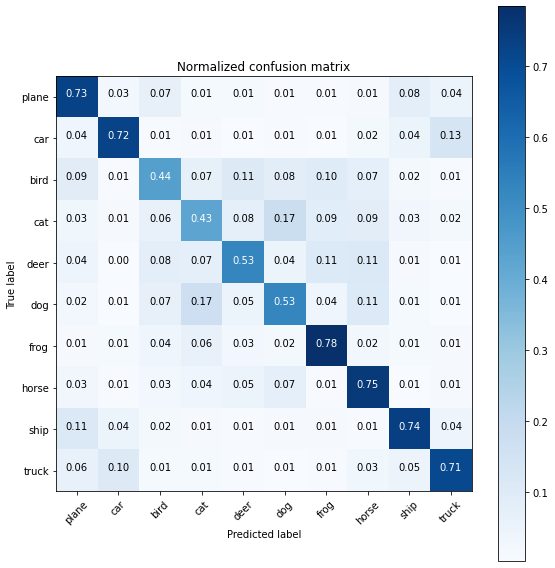

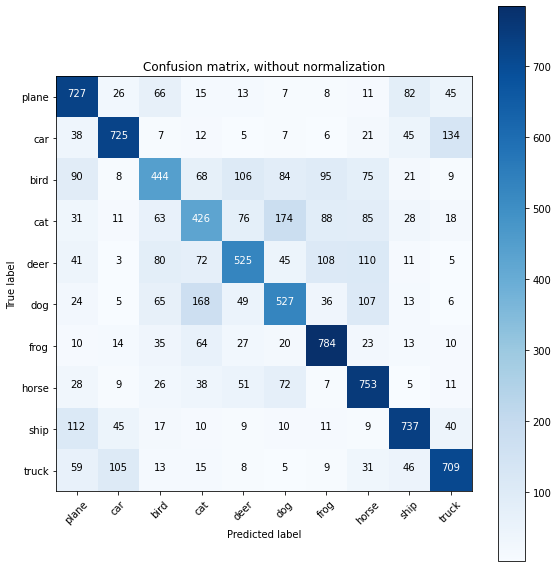

In [33]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

## **ANALYSIS ON SIMPLE NETWORK**

**We can clearly see on the losses plot that the validation loss diverges. It means that we overfit on the training data. This can be due to a high learning rate for instance, however, it is probably first due to a very small batch size in the training. A batch size of only 32 images won't be representative enough of for a 10-class classification problem. Increasing that hyperparameter will help the convergence in the first place. This lack of convergence, and the fact that even the training loss doesn't decrease under 0.8 results in average accuracy results. Especially for some animal classes like cat, dog, bird or deer where the accuracy is either 50% or lower in the confusion matrix.**

# III. Exploring CNN Architectures
The network that you have to tweak is called **MyConvolutionalNetwork**.

**Convolution Formulas**:

The formulas relating the output shape $(C_2, H_2, W_2)$ of the convolution to the input shape $(C_1, H_1, W_1)$ are:


$$ H_2 = \lfloor \frac{H_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ W_2 = \lfloor \frac{W_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ C_2 = \text{number of filters used in the convolution}$$

NOTE: $C_2 = C_1$ in the case of max pooling

where:
- $H_2$: height of the output volume  
- $W_2$: width of the output volume  
- $C_1$: in_channels, number of channels in the input volume
- $C_2$: out_channels

In [34]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

Below is the neural network you have to edit:

In [53]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=0)

        self.conv2 = nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(36, 72, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(72, 144, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(144, 288, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=4, stride=1, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.dp = nn.Dropout2d(0.2) #Dropout layer

        # Size of the output of the last convolution:
        self.flattened_size = 288*4*4

        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        
        # 18x32x32 -> 18x28x28
        x = self.pool(x)

        # shape : 18x28x28 -> 36x28x28
        x = F.relu(self.conv2(x))
        # 36x28x28 -> 36x24x24
        x = self.pool2(x)

        # shape : 36x24x24 -> 72x24x24
        x = F.relu(self.conv3(x))
        # 72x24x24 -> 72x12x12
        x = self.pool3(x)


        # shape : 72x12x12 -> 144x12x12
        x = F.relu(self.conv4(x))
        # 144x12x12 -> 144x9x9
        x = self.pool4(x)

         # shape : 144x9x9 -> 288x9x9
        x = F.relu(self.conv5(x))
        # 288x9x9 -> 288x4x4
        x = self.pool5(x)

        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
       
        x = x.view(-1, self.flattened_size)

        x = F.relu(self.fc1(x))

        #Try dropout of 0.2
        x= self.dp(x)

        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net1 = MyConvolutionalNetwork()
train_history, val_history = train(net1, batch_size=250, n_epochs=20, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 250
n_epochs= 20
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.35 took: 1.68s
Epoch 1, 21% 	 train_loss: 2.12 took: 1.06s
Epoch 1, 31% 	 train_loss: 2.00 took: 1.09s
Epoch 1, 42% 	 train_loss: 1.90 took: 1.08s
Epoch 1, 52% 	 train_loss: 1.87 took: 1.07s
Epoch 1, 63% 	 train_loss: 1.80 took: 1.11s
Epoch 1, 73% 	 train_loss: 1.70 took: 1.08s
Epoch 1, 84% 	 train_loss: 1.67 took: 1.08s
Epoch 1, 95% 	 train_loss: 1.64 took: 1.07s
Validation loss = 1.46
Epoch 2, 10% 	 train_loss: 1.53 took: 1.59s
Epoch 2, 21% 	 train_loss: 1.50 took: 1.09s
Epoch 2, 31% 	 train_loss: 1.49 took: 1.11s
Epoch 2, 42% 	 train_loss: 1.43 took: 1.10s
Epoch 2, 52% 	 train_loss: 1.41 took: 1.09s
Epoch 2, 63% 	 train_loss: 1.36 took: 1.13s
Epoch 2, 73% 	 train_loss: 1.43 took: 1.08s
Epoch 2, 84% 	 train_loss: 1.40 took: 1.08s
Epoch 2, 95% 	 train_loss: 1.35 took: 1.10s
Validation loss = 1.22
Epoch 3, 10% 	 train_loss: 1.28 took: 1.66s
Epoch 3, 21% 	 train_loss: 1.30 took: 1.

### Losses Plot

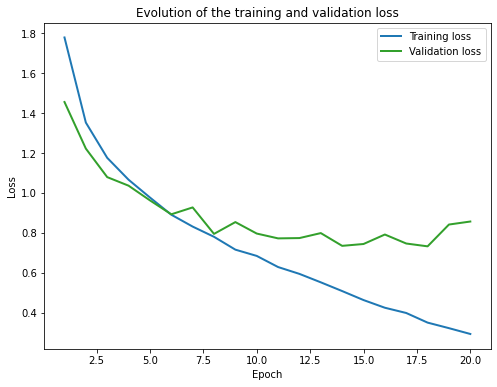

In [ ]:
plot_losses(train_history, val_history)

### Accuracy of the trained model

In [ ]:
compute_accuracy(net)

Accuracy of the network on the 45000 train images: 91.24 %
Accuracy of the network on the 5000 validation images: 76.08 %
Accuracy of the network on the 10000 test images: 75.21 %


In [ ]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        81.50   
car          85.40   
bird         65.60   
cat          54.50   
deer         74.70   
dog          67.30   
frog         81.10   
horse        78.90   
ship         80.20   
truck        82.90   


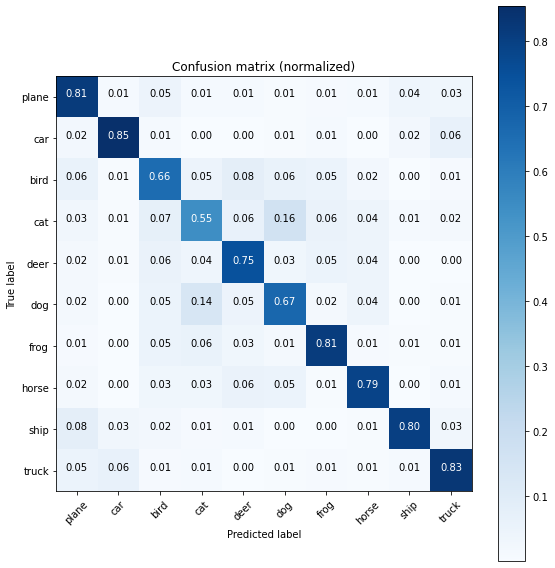

In [ ]:
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Confusion matrix (normalized)')

## **ANALYSIS**

**We created a network with 5 convolutional layers that seemed to improve our overall accuracy sufficiently. After each convolutional layer, the image passes through a MaxPooling layer too. In the end, we have 288 final feature maps of size 4x4. It is rather small but it was a tricky arbitrary decision considering the small input images sizes (32x32). The fully connected part is only made of 2 layers and a dropout probability of O.2. The optimizer used was always ADAM since we did not see any improvement with SGD.**

**For the hyperparameters, setting `batch_size` to 250 seemed a good compromise even it is more computationnaly demanding. Combined with a `learning_rate` at 0.001, we can still see the validation loss diverging. Overall we have better results though, because the deeper network was able to extract more features relevant for classification, and the larger batches prevented too much overfitting. Now we tried to prevent the remaining overfitting with one `Dropout` of 0.2 in the fully connected part though it has not have that much effect. Using the `BatchNorm` has proved to be more efficient in some cases, but we were not able to implement it in a way that it had any positive impact.**

**We observe that this classification problem has its own issues because we are trying to classify labels inside of a "binary" configuration : animals on one side and engines on the other. Inside these two classes, the differenciation between some labels appears harder. For instance, we observed that the accuracy for the 'cat' and 'dog' labels is always lower in the confusion matrix, no matter the network. The complexity of the task explains that we are not able to easily find an optimal configuration and set of hyperparameters.**

In [42]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=250, n_epochs=20, learning_rate=0.0005)

===== HYPERPARAMETERS =====
batch_size= 250
n_epochs= 20
learning_rate= 0.0005
Epoch 1, 10% 	 train_loss: 2.37 took: 1.61s
Epoch 1, 21% 	 train_loss: 2.15 took: 1.10s
Epoch 1, 31% 	 train_loss: 2.02 took: 1.07s
Epoch 1, 42% 	 train_loss: 1.95 took: 1.11s
Epoch 1, 52% 	 train_loss: 1.87 took: 1.07s
Epoch 1, 63% 	 train_loss: 1.82 took: 1.10s
Epoch 1, 73% 	 train_loss: 1.81 took: 1.09s
Epoch 1, 84% 	 train_loss: 1.75 took: 1.07s
Epoch 1, 95% 	 train_loss: 1.70 took: 1.10s
Validation loss = 1.63
Epoch 2, 10% 	 train_loss: 1.69 took: 1.64s
Epoch 2, 21% 	 train_loss: 1.61 took: 1.10s
Epoch 2, 31% 	 train_loss: 1.59 took: 1.09s
Epoch 2, 42% 	 train_loss: 1.59 took: 1.08s
Epoch 2, 52% 	 train_loss: 1.55 took: 1.09s
Epoch 2, 63% 	 train_loss: 1.54 took: 1.09s
Epoch 2, 73% 	 train_loss: 1.47 took: 1.10s
Epoch 2, 84% 	 train_loss: 1.49 took: 1.14s
Epoch 2, 95% 	 train_loss: 1.49 took: 1.11s
Validation loss = 1.42
Epoch 3, 10% 	 train_loss: 1.46 took: 1.65s
Epoch 3, 21% 	 train_loss: 1.42 took: 1

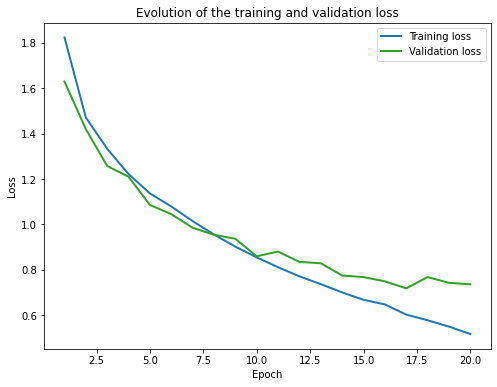

In [43]:
plot_losses(train_history, val_history)

In [44]:
compute_accuracy(net)

Accuracy of the network on the 45000 train images: 80.44 %
Accuracy of the network on the 5000 validation images: 75.06 %
Accuracy of the network on the 10000 test images: 74.03 %


## **ANALYSIS**

**Here, a smaller learning rate at 0.0005 helped the convergence of the validation loss over 20 epochs. We also have a satisfying overall accuracy of 74.03% over the test set. However, we were starting to overfit on the last epochs as we can see.**

## **Learning Rate decay effect on 35 epochs**

In [64]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=300, n_epochs=35, learning_rate=0.0005)

===== HYPERPARAMETERS =====
batch_size= 300
n_epochs= 35
learning_rate= 0.0005
Epoch 1, 10% 	 train_loss: 2.41 took: 1.73s
Epoch 1, 21% 	 train_loss: 2.24 took: 1.10s
Epoch 1, 32% 	 train_loss: 2.14 took: 1.09s
Epoch 1, 42% 	 train_loss: 2.07 took: 1.11s
Epoch 1, 53% 	 train_loss: 2.00 took: 1.07s
Epoch 1, 64% 	 train_loss: 1.94 took: 1.11s
Epoch 1, 74% 	 train_loss: 1.88 took: 1.10s
Epoch 1, 85% 	 train_loss: 1.82 took: 1.09s
Epoch 1, 96% 	 train_loss: 1.81 took: 1.07s
Validation loss = 1.70
Epoch 2, 10% 	 train_loss: 1.78 took: 1.69s
Epoch 2, 21% 	 train_loss: 1.75 took: 1.11s
Epoch 2, 32% 	 train_loss: 1.69 took: 1.09s
Epoch 2, 42% 	 train_loss: 1.67 took: 1.10s
Epoch 2, 53% 	 train_loss: 1.66 took: 1.11s
Epoch 2, 64% 	 train_loss: 1.64 took: 1.11s
Epoch 2, 74% 	 train_loss: 1.58 took: 1.22s
Epoch 2, 85% 	 train_loss: 1.64 took: 1.13s
Epoch 2, 96% 	 train_loss: 1.56 took: 1.07s
Validation loss = 1.44
Epoch 3, 10% 	 train_loss: 1.51 took: 1.70s
Epoch 3, 21% 	 train_loss: 1.52 took: 1

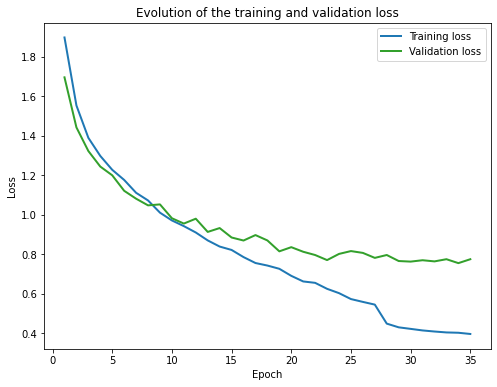

In [68]:
plot_losses(train_history, val_history)

In [66]:
compute_accuracy(net)

Accuracy of the network on the 45000 train images: 86.36 %
Accuracy of the network on the 5000 validation images: 75.06 %
Accuracy of the network on the 10000 test images: 75.12 %


## **ANALYSIS**
**After a longer training, considering the larger batch size (300), the learning rate (0.0005) and the number of epochs (35), we have an overall accuracy of 75.12% on the test set. It is good but not great considering that this configuration was quite time consuming. This test was mainly to see if the learning rate decay would have an effect on a larger number of epochs, but it is not really the case.**

**In the end, we understand that it can be tricky to find the right hyperparameters according to our classification problem and the network architecture. One hyperparameter will only have that much positive effect considering the combination with the others.**

# **Visualize features map to see what the network is learning**

**An interesting way of understanding what is really going on inside the network would be to plot the features learned in the convolutional part for instance.**

In [76]:
children = list(net.children()) #list of layers in model

model_weights = [] # we will save the 5 conv layer weights in this list
conv_layers = [] # we will save the 5 conv layers in this list

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(children)):
    if type(children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(children[i].weight)
        conv_layers.append(children[i])

print(f"Total convolutional layers: {counter}")

Total convolutional layers: 5


### **Visualizing filters from 1st and Last convolutional layers**

In [187]:
#Get the first and last conv layers weights back on cpu
w0 = model_weights[0].cpu() #First conv layer weights
w5 = model_weights[4].cpu() #Last conv layer weights

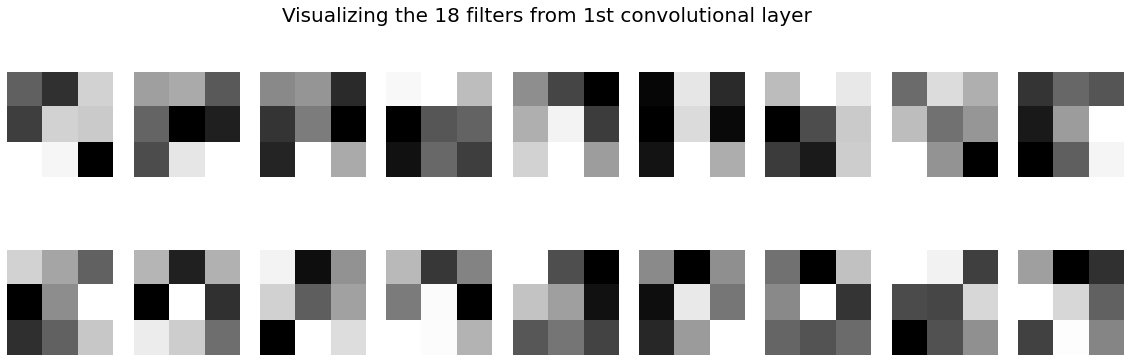

In [185]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 6))

for i, filter in zip(range(len(w0)), w0):
    plt.suptitle('Visualizing the 18 filters from 1st convolutional layer', size=20)
    plt.subplot(2, 9, i+1) # (2,9) because in conv0 we have 18 filters of size (3x3) 
    plt.imshow(filter[0, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

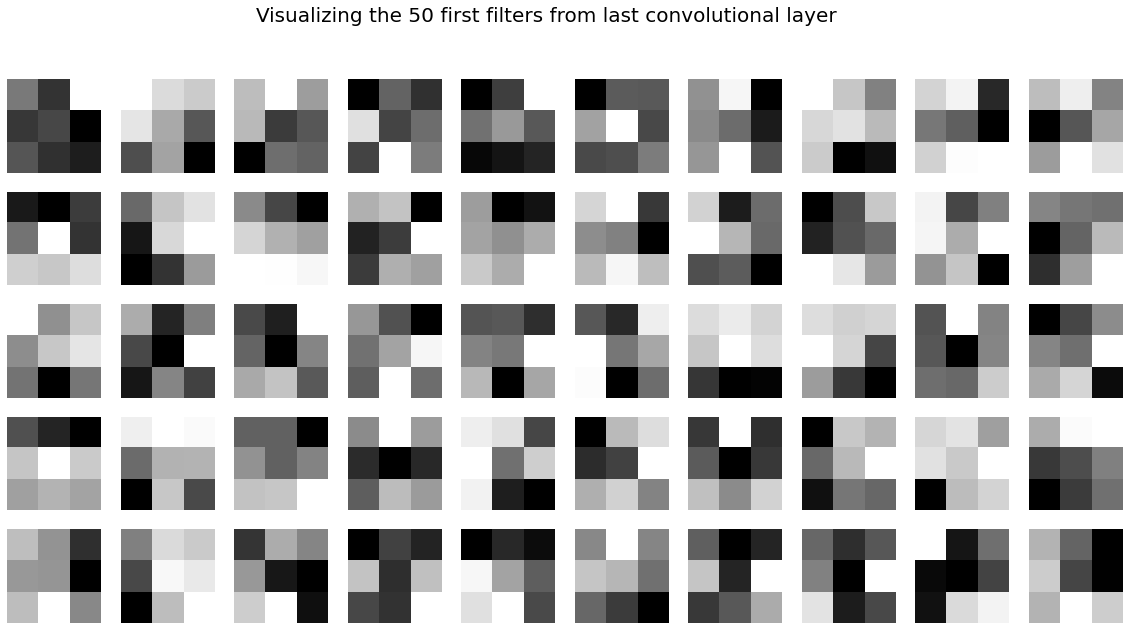

In [191]:
# visualize the last conv layer filters
plt.figure(figsize=(20, 10))

for i, filter in zip(range(50), w5):
    plt.suptitle('Visualizing the 50 first filters from last convolutional layer', size=20)
    plt.subplot(5, 10, i+1) 
    plt.imshow(filter[0, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

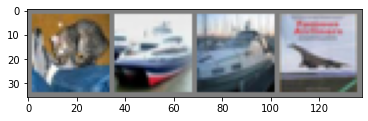

In [228]:
#Get test images examples to pass through the network
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images))

#Get the first image as example and turn it back to a numpy array
img_test = images[0].cpu().numpy()

In [229]:
#Convolution with trained weights as if we were passing images through the network :
import scipy
from scipy import signal

features_conv1 = [] #list of our features from the first conv layer
for i in range(len(w0)):
  features_conv1.append(scipy.ndimage.convolve(img_test, w0[i].detach().numpy()))

print("We have {} features extracted through the 1st convolutional layer".format(len(features_conv1)))

We have 18 features extracted through the 1st convolutional layer


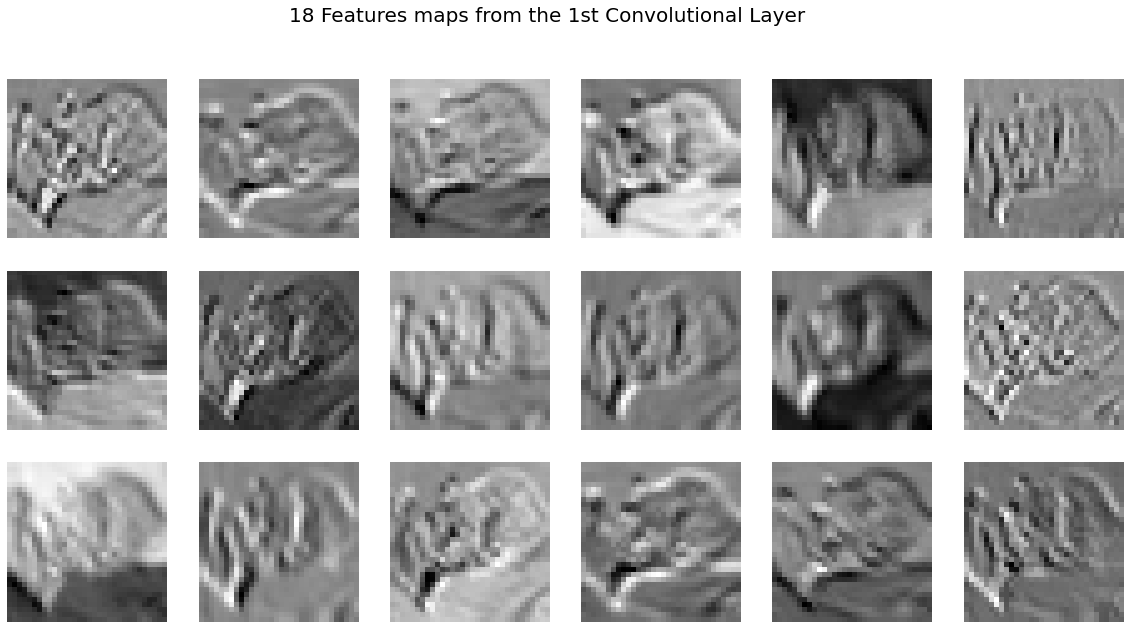

In [231]:
plt.figure(figsize=(20, 10))
for  i in range(len(features_conv1)):
  feature_viz = features_conv1[i][0, :, :] #First channel
# layer_viz = layer_viz.data
# print(layer_viz.size())
  plt.suptitle('18 Features maps from the 1st Convolutional Layer', size = 20)
  plt.subplot(3, 6, i + 1)
  plt.imshow(feature_viz, cmap='gray')
  plt.axis("off")

plt.show()

In [233]:
#Convolutions with last convolutional layer filters

features_conv5 = []
for i in range(len(w5)):
  features_conv5.append(scipy.ndimage.convolve(img_test, w5[i].detach().numpy()))

print("We have {} features extracted through the last convolutional layer".format(len(features_conv5)))


We have 288 features extracted through the last convolutional layer


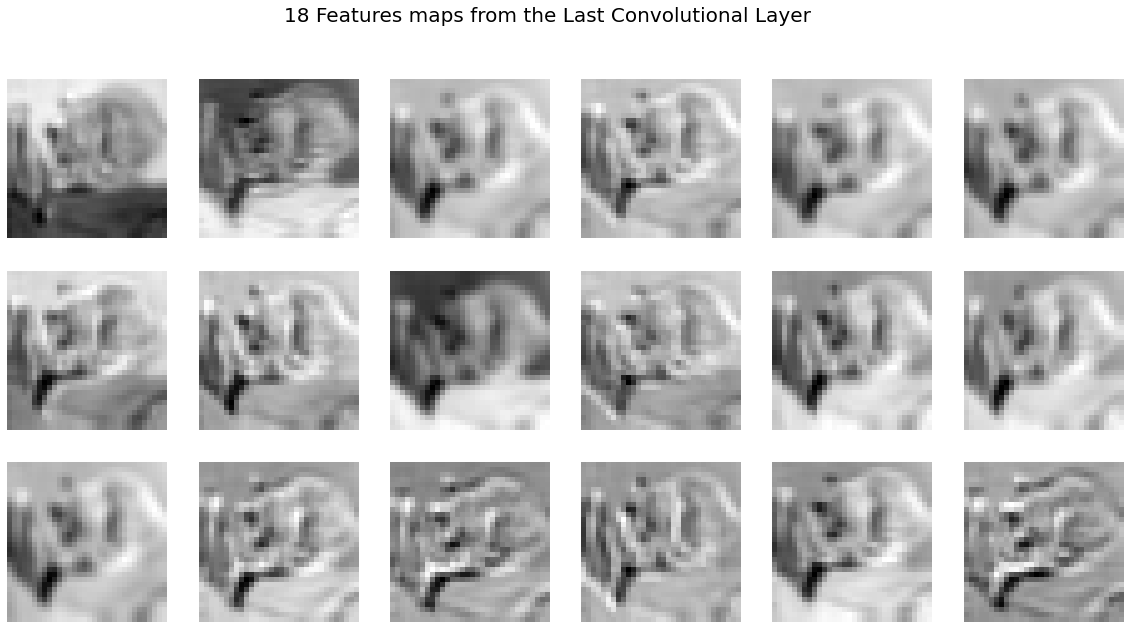

In [235]:
plt.figure(figsize=(20, 10))
for  i, j in zip(range(18), range(50,68)):
  feature_viz = features_conv5[j][0, :, :] #First channel
# layer_viz = layer_viz.data
# print(layer_viz.size())
  plt.suptitle('18 Features maps from the Last Convolutional Layer', size = 20)
  plt.subplot(3, 6, i + 1)
  plt.imshow(feature_viz, cmap='gray')
  plt.axis("off")

plt.show()

### **NOTE**

**Here we can clearly see what we call the "features extraction". The learned weights will extract features such as edges, sharpness, borders, texture, light intensity changes..etc depending on the layer. The deeper layers would extract features more specific to the input data in order to perform classification. The first layers will rather extract general features like shapes, contrast...etc.**

**In reality, the final convolution is performed on the output of the previous convolution..etc. We'll try to illustrate that with the following code.**

In [268]:
#Convolution with trained weights as if we were passing images through the whole network (without maxpooling in order to facilitate the visualization) : 
w1 = model_weights[1].cpu()
w2 = model_weights[2].cpu()
w3 = model_weights[3].cpu()

#Initialize with the first convolution result
input_img = scipy.ndimage.convolve(img_test, w0[0].detach().numpy())

feature_output = [] #Our list of convolutional results
feature_output.append(x1)

for w in [w1, w2, w3, w5]:
  x = scipy.ndimage.convolve(input_img, w[0].detach().numpy())
  input_img = x
  feature_output.append(x)


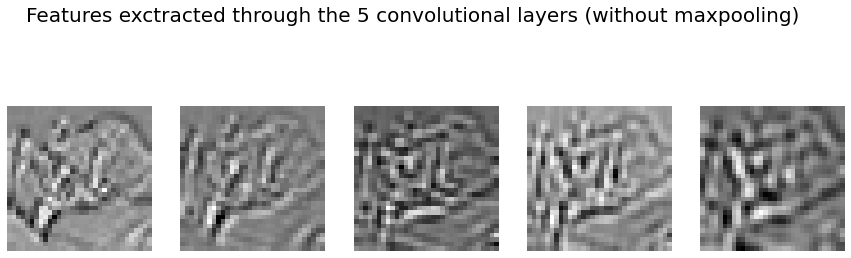

In [269]:
plt.figure(figsize=(15, 5))
for  i, out in zip(range(5), feature_output):
  feature_viz = feature_output[i][0, :, :]

  plt.suptitle('Features exctracted through the 5 convolutional layers (without maxpooling)', size = 20)
  plt.subplot(1, 5, i + 1)
  plt.imshow(feature_viz, cmap='gray')
  plt.axis("off")

plt.show()

## **NOTE**
**Here, we computed the convolution between the input image and the first filter of the first convolutional layer. Then, we computed the convolution of the previous output with the first filter of the next layer..etc. Usually, in very deep networks, the last output is quite sparse as the network has only very few features to extract, especially with the pooling. Here, the size of the input images (32x32) does not really allow us to make a very deep network. Although, if we tried, it would be very time consuming. As a matter of fact, in order for it to be relevant, we need to have enough information on the layers inputs everytime when we add more layers.**

**We actually tried to add 3 more convolutional layers to our previous 5-conv-layer CNN. Results are presented below.**

# **Adding more layers ?**

In [304]:
class CNN8(nn.Module):
    def __init__(self):
        super(CNN8, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=0) #output size 18x28x28

        self.conv2 = nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) #output size 36x26x26

        self.conv3 = nn.Conv2d(36, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) #output size 64x24x24


        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=5, stride=1, padding=0) #output size 128x20x20


        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) #output size 256x18x18

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) #output size 512x16x16

        self.conv7 = nn.Conv2d(512, 700, kernel_size=3, stride=1, padding=1)
        self.pool7 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) #output size 700x14x14

        self.conv8 = nn.Conv2d(700, 900, kernel_size=3, stride=1, padding=1)
        self.pool8 = nn.MaxPool2d(kernel_size=5, stride=1, padding=0) #output size 900x10x10

        self.dp = nn.Dropout2d(0.2) #Dropout layer


        # Size of the output of the last convolution:
        self.flattened_size = 900*10*10
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
   
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = F.relu(self.conv5(x))
        x = self.pool5(x)

        x = F.relu(self.conv6(x))
        x = self.pool6(x)

        x = F.relu(self.conv7(x))
        x = self.pool7(x)

        x = F.relu(self.conv8(x))
        x = self.pool8(x)

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        x = x.view(-1, self.flattened_size)

        x = F.relu(self.fc1(x))

        #Try dropout 
        #x= self.dp(x)

        x = self.fc2(x)
        return x

In [305]:
net8 = CNN8()
train_history, val_history = train(net8, batch_size=250, n_epochs=20, learning_rate=0.0005)

===== HYPERPARAMETERS =====
batch_size= 250
n_epochs= 20
learning_rate= 0.0005
Epoch 1, 10% 	 train_loss: 2.43 took: 17.57s
Epoch 1, 21% 	 train_loss: 2.32 took: 17.54s
Epoch 1, 31% 	 train_loss: 2.16 took: 17.19s
Epoch 1, 42% 	 train_loss: 2.09 took: 16.85s
Epoch 1, 52% 	 train_loss: 2.04 took: 16.81s
Epoch 1, 63% 	 train_loss: 1.96 took: 16.95s
Epoch 1, 73% 	 train_loss: 1.89 took: 17.11s
Epoch 1, 84% 	 train_loss: 1.81 took: 17.09s
Epoch 1, 95% 	 train_loss: 1.73 took: 17.02s
Validation loss = 1.63
Epoch 2, 10% 	 train_loss: 1.72 took: 17.43s
Epoch 2, 21% 	 train_loss: 1.69 took: 16.98s
Epoch 2, 31% 	 train_loss: 1.62 took: 17.01s
Epoch 2, 42% 	 train_loss: 1.60 took: 17.01s
Epoch 2, 52% 	 train_loss: 1.56 took: 17.01s
Epoch 2, 63% 	 train_loss: 1.54 took: 16.99s
Epoch 2, 73% 	 train_loss: 1.52 took: 17.01s
Epoch 2, 84% 	 train_loss: 1.57 took: 16.99s
Epoch 2, 95% 	 train_loss: 1.52 took: 16.98s
Validation loss = 1.39
Epoch 3, 10% 	 train_loss: 1.40 took: 17.44s
Epoch 3, 21% 	 train

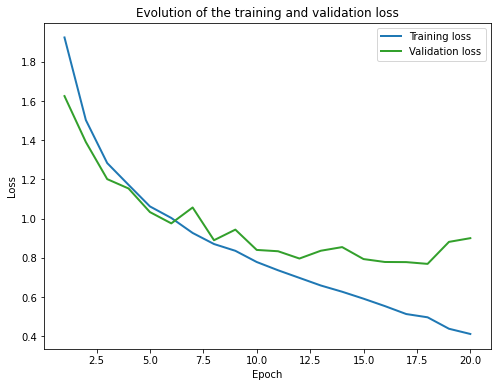

In [306]:
plot_losses(train_history, val_history)

In [307]:
compute_accuracy(net8)

Accuracy of the network on the 45000 train images: 86.21 %
Accuracy of the network on the 5000 validation images: 74.32 %
Accuracy of the network on the 10000 test images: 72.71 %


In [308]:
confusion_matrix = accuracy_per_class(net8)

Class      Accuracy (%)
plane        81.10   
car          84.40   
bird         63.60   
cat          45.40   
deer         71.90   
dog          64.20   
frog         78.30   
horse        77.50   
ship         79.40   
truck        81.30   


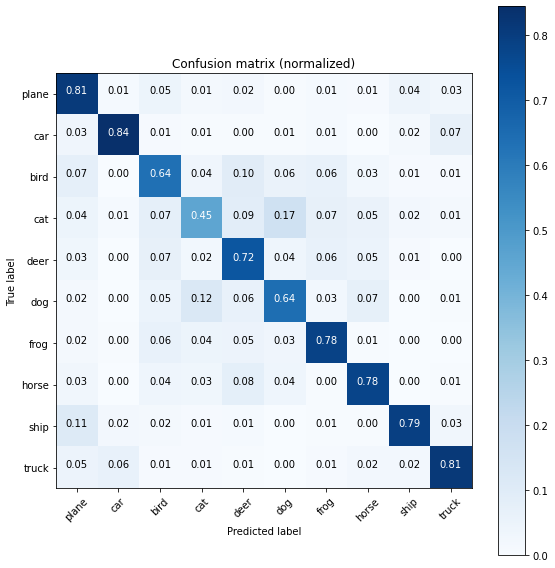

In [309]:
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Confusion matrix (normalized)')

## **ANALYSIS**
**This network has 8 convolutional layers with maxpooling layers that results in a output of size 900*10*10. This starts to be very time consuming because of the number of neurons to update through backpropagation. We also set a large batch size at 250 which is computationally consuming.** 

**We can see that the validation loss still diverges on 20 epochs. Also, we have an overall accuracy of 72.71% on the test set which is not better than before. As explained in the feature map previous section, it is possible that the network is overfitting because of the deeper architecture. Also, it could be that the architecture is not suited in combination of our hyperparameters and the input data.**

# **Test with pretrained network - Transfer Learning with Resnet18**

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 45000 # Max: 50 000 - n_val_samples
n_val_samples = 5000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))  # we can use it to test on a subset
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [ ]:
num_workers = 5
test_batch_size = 4
input_size = 224

transform = transforms.Compose([
        transforms.Resize(input_size), #We need to resize the data because the pretrained network was trained on images of size 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


       dog      horse      horse       bird


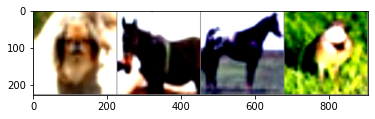

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [ ]:
""" Resnet18
        """
from torchvision import models
num_classes = 10 #Number of classes to predict

In [ ]:
#We set our pretrained CNN
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features #Number of features of last convolutional layer
#Change the final FC layer into 2 layers with dropout of 0.1
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 64), nn.ReLU(inplace=True), nn.Dropout(p=0.1), nn.Linear(64, num_classes))  

In [ ]:
#Change the function to optimize parameters of the fully connected part (not the whole convolutional part)
def createLossAndOptimizer_pt(net, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(net.fc.parameters(), lr=learning_rate)
    return criterion, optimizer

In [ ]:
#Just change the train function so that we optimize only the FC part
def train_pt(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer_pt(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [ ]:
#TRAINING
net = model_pt
train_history, val_history = train_pt(net, batch_size=250, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 250
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.08 took: 26.39s
Epoch 1, 21% 	 train_loss: 0.63 took: 23.88s
Epoch 1, 31% 	 train_loss: 0.55 took: 23.96s
Epoch 1, 42% 	 train_loss: 0.46 took: 23.73s
Epoch 1, 52% 	 train_loss: 0.44 took: 23.79s
Epoch 1, 63% 	 train_loss: 0.45 took: 23.86s
Epoch 1, 73% 	 train_loss: 0.39 took: 23.78s
Epoch 1, 84% 	 train_loss: 0.37 took: 23.74s
Epoch 1, 95% 	 train_loss: 0.38 took: 23.76s
Validation loss = 4.48
Epoch 2, 10% 	 train_loss: 0.31 took: 26.40s
Epoch 2, 21% 	 train_loss: 0.28 took: 23.93s
Epoch 2, 31% 	 train_loss: 0.29 took: 23.75s
Epoch 2, 42% 	 train_loss: 0.28 took: 23.78s
Epoch 2, 52% 	 train_loss: 0.29 took: 23.89s
Epoch 2, 63% 	 train_loss: 0.29 took: 23.80s
Epoch 2, 73% 	 train_loss: 0.26 took: 23.79s
Epoch 2, 84% 	 train_loss: 0.27 took: 23.82s
Epoch 2, 95% 	 train_loss: 0.29 took: 23.79s
Validation loss = 5.26
Epoch 3, 10% 	 train_loss: 0.20 took: 26.08s
Epoch 3, 21% 	 train_

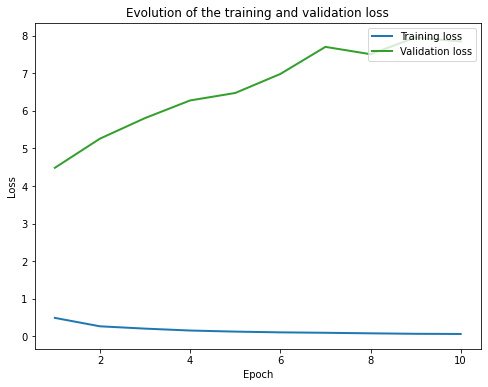

In [ ]:
plot_losses(train_history, val_history)

In [ ]:
compute_accuracy(net)

Accuracy of the network on the 45000 train images: 70.31 %
Accuracy of the network on the 5000 validation images: 21.18 %
Accuracy of the network on the 10000 test images: 68.59 %


In [ ]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        62.50   
car          82.80   
bird         63.50   
cat          50.40   
deer         75.80   
dog          65.60   
frog         69.50   
horse        71.80   
ship         73.90   
truck        74.00   


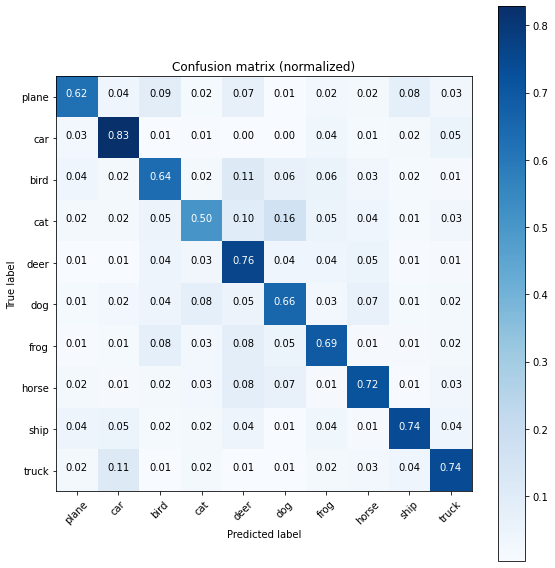

In [ ]:
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Confusion matrix (normalized)')

## **NOTE** 

**We clearly have an issue with this method where we should have only trained the last fully connected part. It ould be interesting to see if the pre trained convolutional part is learning relevant features but we did not have time to make further tests. We still have an overal accuracy of 68%, which is not that bad. Though, with a pretrained network as powerful as ResNet we should have been able to get better results. We note that the input images of the ResNet network have to be of size 224x224 minimum. However, our input images are quite small so this test is a bit biased. We had to resize the images but they are very blurred. This is a point to explore.**

# **Testing with a very large Network**

**We used the architecture developped in those Kaggle kernels :
https://www.kaggle.com/aarooxx/object-recognition-90-88-accuracy
https://www.kaggle.com/kalashnimov/keras-callbacks-with-91-acc
This model, being the largest that we tested is also the one which performs the best. The following network was trained on a training set of 40 000 images and validation set of 10 000 images, unlike the previous architectures presented.**

In [ ]:
#Implement the model
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        # FIRST LAYERS
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, 
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, 
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, 
                               padding=1, stride=2)
        self.dropout1 = nn.Dropout2d()
        # MID LAYERS
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, 
                               padding=1)
        self.conv5 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, 
                               padding=1)
        self.conv6 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, 
                               padding=1, stride=2)
        self.dropout2 = nn.Dropout2d()
        # LAST LAYERS
        self.conv7 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, 
                               padding=1)
        self.conv8 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, 
                               padding=0)
        self.conv9 = nn.Conv2d(in_channels=192, out_channels=10, kernel_size=1, 
                               padding=0)

        
        # Size of the output of the last convolution:
        self.flattened_size = 10*8*8
        self.fc = nn.Linear(self.flattened_size, 10)
    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # 1:  3x32x32 -> 96x32x32
        x = F.relu(self.conv1(x))
        # 2:  96x32x32 -> 96x32x32
        x = F.relu(self.conv2(x))
        # 3:  96x32x32 -> 96x16x16
        x = self.conv3(x)
        x = self.dropout1(x)
        # 4:  96x16x16 -> 192x16x16
        x = F.relu(self.conv4(x))
        # 5:  192x16x16 -> 192x16x16
        x = F.relu(self.conv5(x))
        # 6:  192x16x16 -> 192x8x8
        x = self.conv6(x)
        x = self.dropout2(x)
        # 7:  192x8x8 -> 192x8x8
        x = F.relu(self.conv7(x))
        # 8:  192x8x8 -> 192x8x8
        x = F.relu(self.conv8(x))
        # 9:  192x8x8 -> 10x8x8
        x = self.conv9(x)
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        # 10x8x8 -> 160
        x = x.view(-1, self.flattened_size)
        x = self.fc(x)
        return x

**Results are presented below but we did not have time to run them again in our final notebook.**

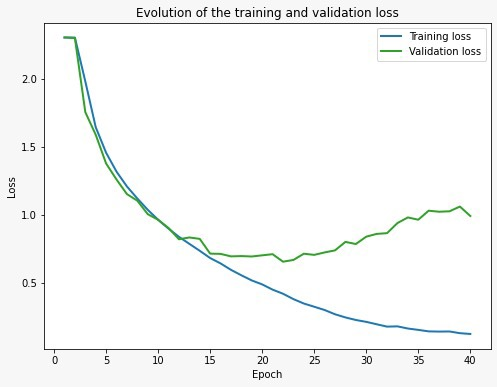

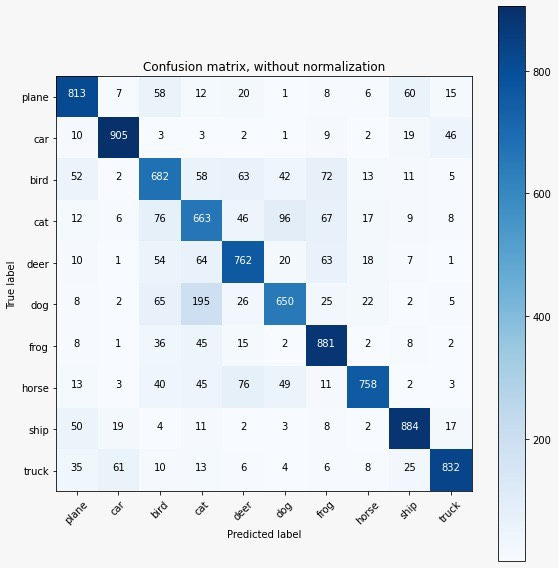

## **NOTE**

**We tested different hyperparameters and optimizer.
The optimizer chosen for the best run is SGD.
For hyperparameters, we chose a dropout of 0.35, a learning rate of 0.01 and 40 epochs (although 25 might have been enough).
The model takes on average 2.3 s per batch for a total of 1018.47s in this run. We obtain an accuracy on the train set of 90.83 %, 78.39 % on the validation set and 78.30 % on the test set.**

**We didn't obtained the promised 91% or 90.88% on the test set because the notebooks using this architecture also augmented the input data. So, data augmentation might be a possible improvement path**